# Install and import libraries

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statistics

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import transformers
from transformers import BertForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup

from seqeval.metrics import f1_score, accuracy_score

2023-06-28 15:01:58.436053: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-28 15:01:58.957681: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Check GPU availability

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2080 Ti'

# **Preprocessing data**

In [3]:
# Reading data
import json


#open the file, and format correctly
f =open('dataset.jsonl', 'r')
helpme = json.dumps(f.readlines(), indent=4)
f.close()

#save better format into file
p = open('sample.txt', 'w')
for i in helpme:
    p.write(i)
p.close()

#open new file, and save each 
j = open('sample.txt', 'r')
parsed = json.loads(j.read())
j.close()

#compile all json dicts into a list
temp = []
for i in parsed:
    parse = json.loads(str(i))
    temp.append(parse)
    


#test it
print(temp[0]['annotations'])
print(temp[0]['text'])
print(temp[0]['annotations'][0]['start_offset'])

[{'label': 6, 'start_offset': 17, 'end_offset': 28, 'user': 1, 'created_at': '2023-06-14T14:36:46.643706Z', 'updated_at': '2023-06-14T14:36:46.643737Z'}, {'label': 2, 'start_offset': 89, 'end_offset': 91, 'user': 1, 'created_at': '2023-06-14T14:37:01.615695Z', 'updated_at': '2023-06-26T13:46:16.108486Z'}, {'label': 6, 'start_offset': 247, 'end_offset': 258, 'user': 1, 'created_at': '2023-06-14T14:37:39.635439Z', 'updated_at': '2023-06-14T14:37:39.635488Z'}, {'label': 3, 'start_offset': 461, 'end_offset': 475, 'user': 1, 'created_at': '2023-06-14T14:38:01.779370Z', 'updated_at': '2023-06-14T14:38:01.779403Z'}, {'label': 1, 'start_offset': 477, 'end_offset': 481, 'user': 1, 'created_at': '2023-06-14T14:38:12.949077Z', 'updated_at': '2023-06-26T14:45:46.411185Z'}, {'label': 2, 'start_offset': 498, 'end_offset': 500, 'user': 1, 'created_at': '2023-06-14T14:39:21.688854Z', 'updated_at': '2023-06-26T13:46:09.687470Z'}, {'label': 6, 'start_offset': 540, 'end_offset': 551, 'user': 1, 'created_

In [4]:
data_tags = ['0','C', 'C-cont' , 'M', 'M-cont', 'Q', 'Q-cont', 'T' , 'T-cont', 'A' , 'A-cont', 'R', 'R-cont']


sentences = []
for i in range(0, len(temp)):
    text = temp[i]['text'].split()
    sentences.append(text)



labeled_parse = []
labels = []
for i in range(0, len(sentences)):
    label_temp =[]
    annotated=[]
    index = 0
    entities = 0
    for j in range(0, len(sentences[i])):
        if len(temp[i]['annotations'])==0:
            break
       
        if index == temp[i]['annotations'][entities]['start_offset']:
            annotated.append([sentences[i][j],data_tags[2*temp[i]['annotations'][entities]['label']-1]])
            label_temp.append(data_tags[2 * temp[i]['annotations'][entities]['label']-1])
            
        elif index >= temp[i]['annotations'][entities]['start_offset'] and index <= temp[i]['annotations'][entities]['end_offset']:
            annotated.append([sentences[i][j],data_tags[(2 * temp[i]['annotations'][entities]['label'] )]])
            label_temp.append(data_tags[(2 * temp[i]['annotations'][entities]['label']-1 ) ])
            
        elif index > temp[i]['annotations'][entities]['end_offset']:
            entities+=1
            annotated.append([sentences[i][j], data_tags[0]])
            label_temp.append(data_tags[0])
            if entities>=len(temp[i]['annotations']):
                break
        else:
            annotated.append([sentences[i][j], data_tags[0]])
            label_temp.append(data_tags[0])
            
        index += (len(sentences[i][j])+1)
    
    labeled_parse.append(annotated)
    labels.append(label_temp)


        
for i in range(0, len(labeled_parse)):
    print()
    print(labeled_parse[i])
    print(labels[i])
    print()


[['The', '0'], ['influence', '0'], ['of', '0'], ['γ-radiation', 'R'], ['on', '0'], ['the', '0'], ['physical', '0'], ['characteristics', '0'], ['and', '0'], ['sorption', '0'], ['properties', '0'], ['for', '0'], ['Am', 'M'], ['of', '0'], ['the', '0'], ['solid', '0'], ['extractant', '0'], ['AXIONIT', '0'], ['MND', '0'], ['40T', '0'], ['(TVEX)', '0'], ['synthesized', '0'], ['by', '0'], ['Axion-Rare', '0'], ['and', '0'], ['Noble', '0'], ['Metals', '0'], ['JSC', '0'], ['(Perm)', '0'], ['was', '0'], ['studied.', '0'], ['With', '0'], ['an', '0'], ['increase', '0'], ['of', '0'], ['the', '0'], ['absorbed', '0'], ['dose', '0'], ['of', '0'], ['γ-radiation,', 'R'], ['the', '0'], ['granulometric', '0'], ['composition,', '0'], ['bulk', '0'], ['density,', '0'], ['and', '0'], ['specific', '0'], ['volume', '0'], ['of', '0'], ['TVEX', '0'], ['change', '0'], ['insignificantly.', '0'], ['The', '0'], ['IR', '0'], ['spectra', '0'], ['of', '0'], ['TVEX', '0'], ['demonstrate', '0'], ['significant', '0'], ['ra

In [5]:

# Determine the list of tags
tag_values = data_tags
print(tag_values)

tag_values.append("PAD")
print(tag_values)

tag2idx = {t: i for i, t in enumerate(tag_values)}
print(tag2idx)
     

['0', 'C', 'C-cont', 'M', 'M-cont', 'Q', 'Q-cont', 'T', 'T-cont', 'A', 'A-cont', 'R', 'R-cont']
['0', 'C', 'C-cont', 'M', 'M-cont', 'Q', 'Q-cont', 'T', 'T-cont', 'A', 'A-cont', 'R', 'R-cont', 'PAD']
{'0': 0, 'C': 1, 'C-cont': 2, 'M': 3, 'M-cont': 4, 'Q': 5, 'Q-cont': 6, 'T': 7, 'T-cont': 8, 'A': 9, 'A-cont': 10, 'R': 11, 'R-cont': 12, 'PAD': 13}


In [6]:
print(sentences[0],"\n",labels[0], "\n", labeled_parse[0])

['The', 'influence', 'of', 'γ-radiation', 'on', 'the', 'physical', 'characteristics', 'and', 'sorption', 'properties', 'for', 'Am', 'of', 'the', 'solid', 'extractant', 'AXIONIT', 'MND', '40T', '(TVEX)', 'synthesized', 'by', 'Axion-Rare', 'and', 'Noble', 'Metals', 'JSC', '(Perm)', 'was', 'studied.', 'With', 'an', 'increase', 'of', 'the', 'absorbed', 'dose', 'of', 'γ-radiation,', 'the', 'granulometric', 'composition,', 'bulk', 'density,', 'and', 'specific', 'volume', 'of', 'TVEX', 'change', 'insignificantly.', 'The', 'IR', 'spectra', 'of', 'TVEX', 'demonstrate', 'significant', 'radiation', 'degradation', 'at', 'an', 'absorbed', 'radiation', 'dose', 'from', '1.4', 'to', '2.5', 'MGy.', 'TVEX', 'is', 'an', 'effective', 'Am', 'sorbent', 'when', 'irradiated', 'to', 'an', 'absorbed', 'γ-radiation', 'dose', 'of', 'no', 'more', 'than', '0.6', 'MGy.', 'At', 'an', 'irradiation', 'dose', 'of', '2.5', 'MGy', 'sorption', 'capacity', 'is', 'significantly', 'reduced.'] 
 ['0', '0', '0', 'R', '0', '0', 

In [7]:
# To use the BERT, you must use the BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('allenai/scibert_scivocab_uncased', do_lower_case=False)


130


In [8]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [9]:
tokenized_texts_and_labels = [ tokenize_and_preserve_labels(sent, labs) for sent, labs in zip(sentences, labels)]

tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [10]:
# MAX_LEN is the maximum length of a sequence
MAX_LEN = 64 # 64 or 128 or ...
bs = 5 # batch size


In [11]:
# Use Padding to equalize the length of sentences
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")


In [12]:
# Do not mask values that are zero
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [13]:
# Split data to train and validation. %90 for train and %10 for validation
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)

# Each mask contains 10% of a sentence
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

# The input of the BERT should be the tensors produced using PyTorch
# So convert all inputs and labels into torch tensors
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)

tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)

tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

# Create the DataLoader for our training set
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

print(train_sampler)

# Create the DataLoader for our validation set
valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


# **Build model**

In [14]:
# Load BERT Model

model = BertForTokenClassification.from_pretrained(
    "allenai/scibert_scivocab_uncased",
    num_labels=len(tag2idx), # The number of output labels
    output_attentions = False, # Whether the model returns attention weights.
    output_hidden_states = False # Whether the model returns all hidden-states.
)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

In [15]:
# Tell PyTorch to run this model on the GPU
model.cuda();

In [16]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr= 1e-5, # learning-rate default is 3e-5
    eps=1e-8 # adam-epsilon default is 1e-8
)


/home/ecasey/anaconda3/envs/torch/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
epochs = 100

max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# **Training**

In [18]:
def acc():
    accuracy_list = []

    for i in range(len(sentences)):

        tokenized_sentence = tokenizer.encode(sentences[i])
        input_ids = torch.tensor([tokenized_sentence]).cuda()

        with torch.no_grad():
            output = model(input_ids)

        label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

        # join bpe split tokens
        tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
        new_tokens, new_labels = [], []
        for token, label_idx in zip(tokens, label_indices[0]):
            if token.startswith("##"):
                new_tokens[-1] = new_tokens[-1] + token[2:]
            else:
                new_labels.append(tag_values[label_idx])
                new_tokens.append(token)

        new_labels = new_labels[1:-2]
        accuracy_list.append(accuracy_score(new_labels, labels[i]))

        #print("\nPredict labels: ",new_labels)
        #print("Actual labels: ",labels[i])

        return statistics.mean(accuracy_list)



In [19]:
## Store the average loss after each epoch so we can plot them.
import copy
loss_values, validation_loss_values = [], []

test_acc = []

for e in trange(epochs, desc="Epoch"):
    
    max_test = 0
    
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("\nAverage train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("\nValidation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]

    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    #print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()
    a = acc()
    test_acc.append(a)
    if a >= max_test:
        max = a
        torch.save(model, "test.txt")
    

Epoch:   0%|                                                                                                 | 0/100 [00:00<?, ?it/s]


Average train loss: 1.6536811639865239

Validation loss: 1.2292462189992268
Validation Accuracy: 0.7357954545454546



Epoch:   1%|▉                                                                                        | 1/100 [00:05<09:04,  5.50s/it]


Average train loss: 0.9440392404794693

Validation loss: 0.8920196294784546
Validation Accuracy: 0.7727272727272727



Epoch:   2%|█▊                                                                                       | 2/100 [00:10<08:18,  5.08s/it]


Average train loss: 0.6579387995103995

Validation loss: 0.6238118410110474
Validation Accuracy: 0.8210227272727273



Epoch:   3%|██▋                                                                                      | 3/100 [00:15<07:58,  4.93s/it]


Average train loss: 0.46598633751273155

Validation loss: 0.47238777081171673
Validation Accuracy: 0.8409090909090909



Epoch:   4%|███▌                                                                                     | 4/100 [00:19<07:47,  4.87s/it]


Average train loss: 0.33838585453728837

Validation loss: 0.36431049307187396
Validation Accuracy: 0.8636363636363636



Epoch:   5%|████▍                                                                                    | 5/100 [00:24<07:40,  4.85s/it]


Average train loss: 0.25613070900241536

Validation loss: 0.3285170296827952
Validation Accuracy: 0.8849431818181818



Epoch:   6%|█████▎                                                                                   | 6/100 [00:29<07:46,  4.97s/it]


Average train loss: 0.2130391194174687

Validation loss: 0.31426069140434265
Validation Accuracy: 0.8877840909090909



Epoch:   7%|██████▏                                                                                  | 7/100 [00:34<07:39,  4.94s/it]


Average train loss: 0.16996790251384178

Validation loss: 0.3135000964005788
Validation Accuracy: 0.8792613636363636



Epoch:   8%|███████                                                                                  | 8/100 [00:39<07:31,  4.91s/it]


Average train loss: 0.13338749995455146

Validation loss: 0.293809711933136
Validation Accuracy: 0.8920454545454546



Epoch:   9%|████████                                                                                 | 9/100 [00:44<07:17,  4.81s/it]


Average train loss: 0.10818821207309763

Validation loss: 0.3197685480117798
Validation Accuracy: 0.8892045454545454



Epoch:  10%|████████▊                                                                               | 10/100 [00:48<07:13,  4.81s/it]


Average train loss: 0.07993984323305388

Validation loss: 0.27266330520311993
Validation Accuracy: 0.8991477272727273



Epoch:  11%|█████████▋                                                                              | 11/100 [00:53<07:06,  4.79s/it]


Average train loss: 0.07019880359681945

Validation loss: 0.31171463429927826
Validation Accuracy: 0.890625



Epoch:  12%|██████████▌                                                                             | 12/100 [00:58<07:00,  4.78s/it]


Average train loss: 0.0566821718433251

Validation loss: 0.2971290399630864
Validation Accuracy: 0.8977272727272727



Epoch:  13%|███████████▍                                                                            | 13/100 [01:03<06:56,  4.79s/it]


Average train loss: 0.0520008122936512

Validation loss: 0.32028352717558545
Validation Accuracy: 0.9005681818181818



Epoch:  14%|████████████▎                                                                           | 14/100 [01:08<06:52,  4.80s/it]


Average train loss: 0.032883912596541144

Validation loss: 0.3176076064507167
Validation Accuracy: 0.8991477272727273



Epoch:  15%|█████████████▏                                                                          | 15/100 [01:13<06:52,  4.86s/it]


Average train loss: 0.0314978517126292

Validation loss: 0.3091258853673935
Validation Accuracy: 0.9105113636363636



Epoch:  16%|██████████████                                                                          | 16/100 [01:17<06:47,  4.85s/it]


Average train loss: 0.02586421765348253

Validation loss: 0.31994643807411194
Validation Accuracy: 0.9048295454545454



Epoch:  17%|██████████████▉                                                                         | 17/100 [01:22<06:43,  4.86s/it]


Average train loss: 0.020431595054105856

Validation loss: 0.3293658643960953
Validation Accuracy: 0.9019886363636364



Epoch:  18%|███████████████▊                                                                        | 18/100 [01:27<06:40,  4.88s/it]


Average train loss: 0.020457200803017866

Validation loss: 0.2968879093726476
Validation Accuracy: 0.9161931818181818



Epoch:  19%|████████████████▋                                                                       | 19/100 [01:32<06:34,  4.87s/it]


Average train loss: 0.0161713884153869

Validation loss: 0.3236422886451085
Validation Accuracy: 0.9133522727272727



Epoch:  20%|█████████████████▌                                                                      | 20/100 [01:37<06:29,  4.87s/it]


Average train loss: 0.01638325159243929

Validation loss: 0.30162298679351807
Validation Accuracy: 0.921875



Epoch:  21%|██████████████████▍                                                                     | 21/100 [01:42<06:23,  4.86s/it]


Average train loss: 0.011810219322796911

Validation loss: 0.3322021613518397
Validation Accuracy: 0.9090909090909091



Epoch:  22%|███████████████████▎                                                                    | 22/100 [01:47<06:18,  4.85s/it]


Average train loss: 0.010734397365013137

Validation loss: 0.30699458221594494
Validation Accuracy: 0.9232954545454546



Epoch:  23%|████████████████████▏                                                                   | 23/100 [01:51<06:12,  4.84s/it]


Average train loss: 0.008078838625806384

Validation loss: 0.3561393866936366
Validation Accuracy: 0.9147727272727273



Epoch:  24%|█████████████████████                                                                   | 24/100 [01:56<06:09,  4.86s/it]


Average train loss: 0.006089327764736178

Validation loss: 0.3137824088335037
Validation Accuracy: 0.9176136363636364



Epoch:  25%|██████████████████████                                                                  | 25/100 [02:01<06:04,  4.85s/it]


Average train loss: 0.005798573440794523

Validation loss: 0.32791795829931897
Validation Accuracy: 0.9190340909090909



Epoch:  26%|██████████████████████▉                                                                 | 26/100 [02:06<05:58,  4.84s/it]


Average train loss: 0.00663840970567738

Validation loss: 0.3558294822772344
Validation Accuracy: 0.9133522727272727



Epoch:  27%|███████████████████████▊                                                                | 27/100 [02:11<05:53,  4.85s/it]


Average train loss: 0.006502018300428365

Validation loss: 0.35163438816865283
Validation Accuracy: 0.9119318181818182



Epoch:  28%|████████████████████████▋                                                               | 28/100 [02:16<05:51,  4.89s/it]


Average train loss: 0.0072479805870292085

Validation loss: 0.35770854353904724
Validation Accuracy: 0.9161931818181818



Epoch:  29%|█████████████████████████▌                                                              | 29/100 [02:21<05:46,  4.88s/it]


Average train loss: 0.0034993714968247027

Validation loss: 0.35035479565461475
Validation Accuracy: 0.9204545454545454



Epoch:  30%|██████████████████████████▍                                                             | 30/100 [02:26<05:43,  4.91s/it]


Average train loss: 0.006540082104038447

Validation loss: 0.33353959520657855
Validation Accuracy: 0.9275568181818182



Epoch:  31%|███████████████████████████▎                                                            | 31/100 [02:31<05:43,  4.97s/it]


Average train loss: 0.002755335754045518

Validation loss: 0.3978376140197118
Validation Accuracy: 0.9090909090909091



Epoch:  32%|████████████████████████████▏                                                           | 32/100 [02:36<05:40,  5.01s/it]


Average train loss: 0.0022315750781369084

Validation loss: 0.3753049323956172
Validation Accuracy: 0.9105113636363636



Epoch:  33%|█████████████████████████████                                                           | 33/100 [02:41<05:30,  4.94s/it]


Average train loss: 0.0030384814090211876

Validation loss: 0.4368400226036708
Validation Accuracy: 0.9119318181818182



Epoch:  34%|█████████████████████████████▉                                                          | 34/100 [02:45<05:22,  4.89s/it]


Average train loss: 0.0015026434751537938

Validation loss: 0.39769916236400604
Validation Accuracy: 0.9119318181818182



Epoch:  35%|██████████████████████████████▊                                                         | 35/100 [02:50<05:17,  4.88s/it]


Average train loss: 0.002192967088679628

Validation loss: 0.40745694438616437
Validation Accuracy: 0.9105113636363636



Epoch:  36%|███████████████████████████████▋                                                        | 36/100 [02:55<05:12,  4.88s/it]


Average train loss: 0.0014657665572788876

Validation loss: 0.3867751012245814
Validation Accuracy: 0.9105113636363636



Epoch:  37%|████████████████████████████████▌                                                       | 37/100 [03:00<05:06,  4.86s/it]


Average train loss: 0.0037274760397849604

Validation loss: 0.40852339069048565
Validation Accuracy: 0.9090909090909091



Epoch:  38%|█████████████████████████████████▍                                                      | 38/100 [03:05<05:04,  4.90s/it]


Average train loss: 0.005098702281732888

Validation loss: 0.3943282465140025
Validation Accuracy: 0.9133522727272727



Epoch:  39%|██████████████████████████████████▎                                                     | 39/100 [03:10<04:59,  4.91s/it]


Average train loss: 0.0033843879888687902

Validation loss: 0.4285958607991536
Validation Accuracy: 0.9105113636363636



Epoch:  40%|███████████████████████████████████▏                                                    | 40/100 [03:15<04:54,  4.91s/it]


Average train loss: 0.0031349924865935463

Validation loss: 0.4286766896645228
Validation Accuracy: 0.9076704545454546



Epoch:  41%|████████████████████████████████████                                                    | 41/100 [03:20<04:53,  4.97s/it]


Average train loss: 0.0013762304879492149

Validation loss: 0.438317875067393
Validation Accuracy: 0.9090909090909091



Epoch:  42%|████████████████████████████████████▉                                                   | 42/100 [03:25<04:47,  4.95s/it]


Average train loss: 0.0020017152031262717

Validation loss: 0.43306201696395874
Validation Accuracy: 0.9090909090909091



Epoch:  43%|█████████████████████████████████████▊                                                  | 43/100 [03:30<04:40,  4.93s/it]


Average train loss: 0.0034915468022518326

Validation loss: 0.4294838110605876
Validation Accuracy: 0.9105113636363636



Epoch:  44%|██████████████████████████████████████▋                                                 | 44/100 [03:35<04:34,  4.91s/it]


Average train loss: 0.0035904719225072768

Validation loss: 0.369632825255394
Validation Accuracy: 0.9176136363636364



Epoch:  45%|███████████████████████████████████████▌                                                | 45/100 [03:39<04:28,  4.88s/it]


Average train loss: 0.0009406354887081155

Validation loss: 0.40602321922779083
Validation Accuracy: 0.9176136363636364



Epoch:  46%|████████████████████████████████████████▍                                               | 46/100 [03:44<04:23,  4.88s/it]


Average train loss: 0.0009435904272928989

Validation loss: 0.3770313213268916
Validation Accuracy: 0.9176136363636364



Epoch:  47%|█████████████████████████████████████████▎                                              | 47/100 [03:49<04:20,  4.91s/it]


Average train loss: 0.00222623296334253

Validation loss: 0.39920436839262646
Validation Accuracy: 0.9147727272727273



Epoch:  48%|██████████████████████████████████████████▏                                             | 48/100 [03:54<04:15,  4.92s/it]


Average train loss: 0.0006796339706246121

Validation loss: 0.39768968522548676
Validation Accuracy: 0.9190340909090909



Epoch:  49%|███████████████████████████████████████████                                             | 49/100 [03:59<04:10,  4.91s/it]


Average train loss: 0.0012393362461201225

Validation loss: 0.37779149909814197
Validation Accuracy: 0.9204545454545454



Epoch:  50%|████████████████████████████████████████████                                            | 50/100 [04:04<04:04,  4.89s/it]


Average train loss: 0.0014371117746729094

Validation loss: 0.39099080860614777
Validation Accuracy: 0.9204545454545454



Epoch:  51%|████████████████████████████████████████████▉                                           | 51/100 [04:09<04:02,  4.95s/it]


Average train loss: 0.002945665328297764

Validation loss: 0.3992471595605214
Validation Accuracy: 0.9161931818181818



Epoch:  52%|█████████████████████████████████████████████▊                                          | 52/100 [04:14<03:55,  4.92s/it]


Average train loss: 0.0008680492925729292

Validation loss: 0.382272665699323
Validation Accuracy: 0.9147727272727273



Epoch:  53%|██████████████████████████████████████████████▋                                         | 53/100 [04:19<03:49,  4.88s/it]


Average train loss: 0.0009426862173616731

Validation loss: 0.36564334233601886
Validation Accuracy: 0.9204545454545454



Epoch:  54%|███████████████████████████████████████████████▌                                        | 54/100 [04:23<03:42,  4.85s/it]


Average train loss: 0.0007003378256437524

Validation loss: 0.4061354969938596
Validation Accuracy: 0.9147727272727273



Epoch:  55%|████████████████████████████████████████████████▍                                       | 55/100 [04:29<03:45,  5.00s/it]


Average train loss: 0.0011876364163375304

Validation loss: 0.38799819846947986
Validation Accuracy: 0.9161931818181818



Epoch:  56%|█████████████████████████████████████████████████▎                                      | 56/100 [04:34<03:37,  4.95s/it]


Average train loss: 0.0021420994780783076

Validation loss: 0.3872162103652954
Validation Accuracy: 0.9133522727272727



Epoch:  57%|██████████████████████████████████████████████████▏                                     | 57/100 [04:38<03:31,  4.91s/it]


Average train loss: 0.0005178116346845248

Validation loss: 0.3850729564825694
Validation Accuracy: 0.9133522727272727



Epoch:  58%|███████████████████████████████████████████████████                                     | 58/100 [04:43<03:26,  4.91s/it]


Average train loss: 0.0006235603783958746

Validation loss: 0.38929350674152374
Validation Accuracy: 0.9133522727272727



Epoch:  59%|███████████████████████████████████████████████████▉                                    | 59/100 [04:48<03:21,  4.91s/it]


Average train loss: 0.0005436410113664655

Validation loss: 0.4204198593894641
Validation Accuracy: 0.9161931818181818



Epoch:  60%|████████████████████████████████████████████████████▊                                   | 60/100 [04:53<03:14,  4.87s/it]


Average train loss: 0.000406297117175806

Validation loss: 0.4114360511302948
Validation Accuracy: 0.9176136363636364



Epoch:  61%|█████████████████████████████████████████████████████▋                                  | 61/100 [04:58<03:09,  4.87s/it]


Average train loss: 0.0006536060985429989

Validation loss: 0.39264824489752453
Validation Accuracy: 0.9133522727272727



Epoch:  62%|██████████████████████████████████████████████████████▌                                 | 62/100 [05:03<03:05,  4.87s/it]


Average train loss: 0.0005038596009399043

Validation loss: 0.3976898441712062
Validation Accuracy: 0.9176136363636364



Epoch:  63%|███████████████████████████████████████████████████████▍                                | 63/100 [05:08<03:01,  4.89s/it]


Average train loss: 0.00040206979307792307

Validation loss: 0.3953719139099121
Validation Accuracy: 0.9190340909090909



Epoch:  64%|████████████████████████████████████████████████████████▎                               | 64/100 [05:13<02:55,  4.88s/it]


Average train loss: 0.00037175306655020296

Validation loss: 0.39057255287965137
Validation Accuracy: 0.9190340909090909



Epoch:  65%|█████████████████████████████████████████████████████████▏                              | 65/100 [05:18<02:51,  4.90s/it]


Average train loss: 0.0003418070185337759

Validation loss: 0.4003082563479741
Validation Accuracy: 0.9161931818181818



Epoch:  66%|██████████████████████████████████████████████████████████                              | 66/100 [05:22<02:45,  4.88s/it]


Average train loss: 0.0003661195720875791

Validation loss: 0.3994755099217097
Validation Accuracy: 0.9161931818181818



Epoch:  67%|██████████████████████████████████████████████████████████▉                             | 67/100 [05:27<02:41,  4.90s/it]


Average train loss: 0.00037192644413153175

Validation loss: 0.41414110859235126
Validation Accuracy: 0.9147727272727273



Epoch:  68%|███████████████████████████████████████████████████████████▊                            | 68/100 [05:32<02:36,  4.90s/it]


Average train loss: 0.0006690767980520226

Validation loss: 0.40925069401661557
Validation Accuracy: 0.9147727272727273



Epoch:  69%|████████████████████████████████████████████████████████████▋                           | 69/100 [05:37<02:31,  4.89s/it]


Average train loss: 0.0008243186039180728

Validation loss: 0.41712002207835513
Validation Accuracy: 0.9147727272727273



Epoch:  70%|█████████████████████████████████████████████████████████████▌                          | 70/100 [05:42<02:26,  4.90s/it]


Average train loss: 0.00085278126061894

Validation loss: 0.4123299221197764
Validation Accuracy: 0.9176136363636364



Epoch:  71%|██████████████████████████████████████████████████████████████▍                         | 71/100 [05:47<02:21,  4.89s/it]


Average train loss: 0.0003451371903793188

Validation loss: 0.40613796810309094
Validation Accuracy: 0.9190340909090909



Epoch:  72%|███████████████████████████████████████████████████████████████▎                        | 72/100 [05:52<02:16,  4.89s/it]


Average train loss: 0.0003619288145273458

Validation loss: 0.4031415929396947
Validation Accuracy: 0.9204545454545454



Epoch:  73%|████████████████████████████████████████████████████████████████▏                       | 73/100 [05:57<02:12,  4.91s/it]


Average train loss: 0.0003568680319100774

Validation loss: 0.40278565883636475
Validation Accuracy: 0.9161931818181818



Epoch:  74%|█████████████████████████████████████████████████████████████████                       | 74/100 [06:02<02:07,  4.91s/it]


Average train loss: 0.0004048572463943856

Validation loss: 0.4122234731912613
Validation Accuracy: 0.9161931818181818



Epoch:  75%|██████████████████████████████████████████████████████████████████                      | 75/100 [06:07<02:02,  4.91s/it]


Average train loss: 0.001699792161161895

Validation loss: 0.41644978026549023
Validation Accuracy: 0.9147727272727273



Epoch:  76%|██████████████████████████████████████████████████████████████████▉                     | 76/100 [06:11<01:57,  4.91s/it]


Average train loss: 0.0005158552915721278

Validation loss: 0.4199876089890798
Validation Accuracy: 0.9147727272727273



Epoch:  77%|███████████████████████████████████████████████████████████████████▊                    | 77/100 [06:16<01:53,  4.93s/it]


Average train loss: 0.0013413567812676774

Validation loss: 0.4065476655960083
Validation Accuracy: 0.9176136363636364



Epoch:  78%|████████████████████████████████████████████████████████████████████▋                   | 78/100 [06:21<01:49,  4.96s/it]


Average train loss: 0.00039112355079851113

Validation loss: 0.4086548214157422
Validation Accuracy: 0.9190340909090909



Epoch:  79%|█████████████████████████████████████████████████████████████████████▌                  | 79/100 [06:26<01:43,  4.92s/it]


Average train loss: 0.0014808547415062396

Validation loss: 0.4123399779200554
Validation Accuracy: 0.9176136363636364



Epoch:  80%|██████████████████████████████████████████████████████████████████████▍                 | 80/100 [06:32<01:40,  5.03s/it]


Average train loss: 0.00034946763419914834

Validation loss: 0.4009787042935689
Validation Accuracy: 0.9204545454545454



Epoch:  81%|███████████████████████████████████████████████████████████████████████▎                | 81/100 [06:36<01:34,  4.99s/it]


Average train loss: 0.0002812228867696831

Validation loss: 0.4002254381775856
Validation Accuracy: 0.9204545454545454



Epoch:  82%|████████████████████████████████████████████████████████████████████████▏               | 82/100 [06:41<01:29,  4.96s/it]


Average train loss: 0.00033206378611794207

Validation loss: 0.4013766869902611
Validation Accuracy: 0.9204545454545454



Epoch:  83%|█████████████████████████████████████████████████████████████████████████               | 83/100 [06:46<01:24,  4.94s/it]


Average train loss: 0.0002680871202755952

Validation loss: 0.3988156815369924
Validation Accuracy: 0.9204545454545454



Epoch:  84%|█████████████████████████████████████████████████████████████████████████▉              | 84/100 [06:51<01:19,  4.94s/it]


Average train loss: 0.001340876492880246

Validation loss: 0.4051152567068736
Validation Accuracy: 0.9190340909090909



Epoch:  85%|██████████████████████████████████████████████████████████████████████████▊             | 85/100 [06:56<01:13,  4.92s/it]


Average train loss: 0.00031646472962165717

Validation loss: 0.4060971389214198
Validation Accuracy: 0.9176136363636364



Epoch:  86%|███████████████████████████████████████████████████████████████████████████▋            | 86/100 [07:01<01:08,  4.91s/it]


Average train loss: 0.00037146618524275254

Validation loss: 0.4097670614719391
Validation Accuracy: 0.9176136363636364



Epoch:  87%|████████████████████████████████████████████████████████████████████████████▌           | 87/100 [07:06<01:04,  4.93s/it]


Average train loss: 0.00030892733472380013

Validation loss: 0.4011230319738388
Validation Accuracy: 0.9161931818181818



Epoch:  88%|█████████████████████████████████████████████████████████████████████████████▍          | 88/100 [07:11<00:59,  4.94s/it]


Average train loss: 0.00037027164701915655

Validation loss: 0.41046154002348584
Validation Accuracy: 0.9161931818181818



Epoch:  89%|██████████████████████████████████████████████████████████████████████████████▎         | 89/100 [07:16<00:54,  4.93s/it]


Average train loss: 0.00042589720275524695

Validation loss: 0.4195936744411786
Validation Accuracy: 0.9147727272727273



Epoch:  90%|███████████████████████████████████████████████████████████████████████████████▏        | 90/100 [07:21<00:49,  4.94s/it]


Average train loss: 0.0004060161524345555

Validation loss: 0.41223899523417157
Validation Accuracy: 0.9176136363636364



Epoch:  91%|████████████████████████████████████████████████████████████████████████████████        | 91/100 [07:26<00:44,  4.94s/it]


Average train loss: 0.0007319958179626459

Validation loss: 0.4291603888074557
Validation Accuracy: 0.9147727272727273



Epoch:  92%|████████████████████████████████████████████████████████████████████████████████▉       | 92/100 [07:31<00:39,  5.00s/it]


Average train loss: 0.00035030570810098044

Validation loss: 0.4311852976679802
Validation Accuracy: 0.9147727272727273



Epoch:  93%|█████████████████████████████████████████████████████████████████████████████████▊      | 93/100 [07:36<00:35,  5.02s/it]


Average train loss: 0.0006474120746133849

Validation loss: 0.42946632703145343
Validation Accuracy: 0.9147727272727273



Epoch:  94%|██████████████████████████████████████████████████████████████████████████████████▋     | 94/100 [07:41<00:30,  5.06s/it]


Average train loss: 0.0004055155416911778

Validation loss: 0.4262688681483269
Validation Accuracy: 0.9147727272727273



Epoch:  95%|███████████████████████████████████████████████████████████████████████████████████▌    | 95/100 [07:46<00:25,  5.03s/it]


Average train loss: 0.0002511716793378582

Validation loss: 0.4263988882303238
Validation Accuracy: 0.9147727272727273



Epoch:  96%|████████████████████████████████████████████████████████████████████████████████████▍   | 96/100 [07:51<00:19,  4.98s/it]


Average train loss: 0.000262442891956501

Validation loss: 0.42680395146210987
Validation Accuracy: 0.9161931818181818



Epoch:  97%|█████████████████████████████████████████████████████████████████████████████████████▎  | 97/100 [07:56<00:14,  4.97s/it]


Average train loss: 0.0002550471926952014

Validation loss: 0.4269491086403529
Validation Accuracy: 0.9161931818181818



Epoch:  98%|██████████████████████████████████████████████████████████████████████████████████████▏ | 98/100 [08:01<00:09,  4.95s/it]


Average train loss: 0.00029674897632503416

Validation loss: 0.42667606969674426
Validation Accuracy: 0.9161931818181818



Epoch:  99%|███████████████████████████████████████████████████████████████████████████████████████ | 99/100 [08:06<00:04,  4.91s/it]


Average train loss: 0.0002687297243634627

Validation loss: 0.42653899888197583
Validation Accuracy: 0.9161931818181818



Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:10<00:00,  4.91s/it]


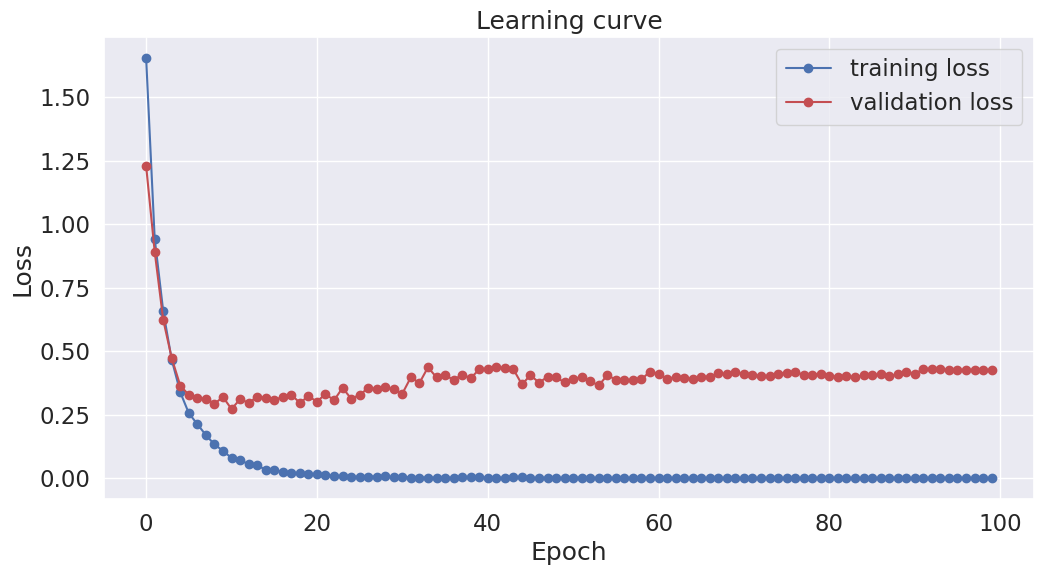

In [20]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Performance on test data

In [21]:
print(acc())

0.8316831683168316


In [22]:
print(test_acc)

[0.9108910891089109, 0.8910891089108911, 0.8613861386138614, 0.8613861386138614, 0.8613861386138614, 0.8514851485148515, 0.8613861386138614, 0.8613861386138614, 0.8514851485148515, 0.8415841584158416, 0.8316831683168316, 0.8118811881188119, 0.8415841584158416, 0.8415841584158416, 0.8415841584158416, 0.8415841584158416, 0.8217821782178217, 0.8316831683168316, 0.8316831683168316, 0.8316831683168316, 0.8316831683168316, 0.8316831683168316, 0.8415841584158416, 0.8316831683168316, 0.8316831683168316, 0.8316831683168316, 0.8118811881188119, 0.8118811881188119, 0.801980198019802, 0.8217821782178217, 0.8415841584158416, 0.801980198019802, 0.8316831683168316, 0.8217821782178217, 0.8118811881188119, 0.8118811881188119, 0.8118811881188119, 0.8118811881188119, 0.8316831683168316, 0.8316831683168316, 0.8316831683168316, 0.8316831683168316, 0.8316831683168316, 0.8217821782178217, 0.8316831683168316, 0.8118811881188119, 0.8415841584158416, 0.8415841584158416, 0.8217821782178217, 0.8316831683168316, 0

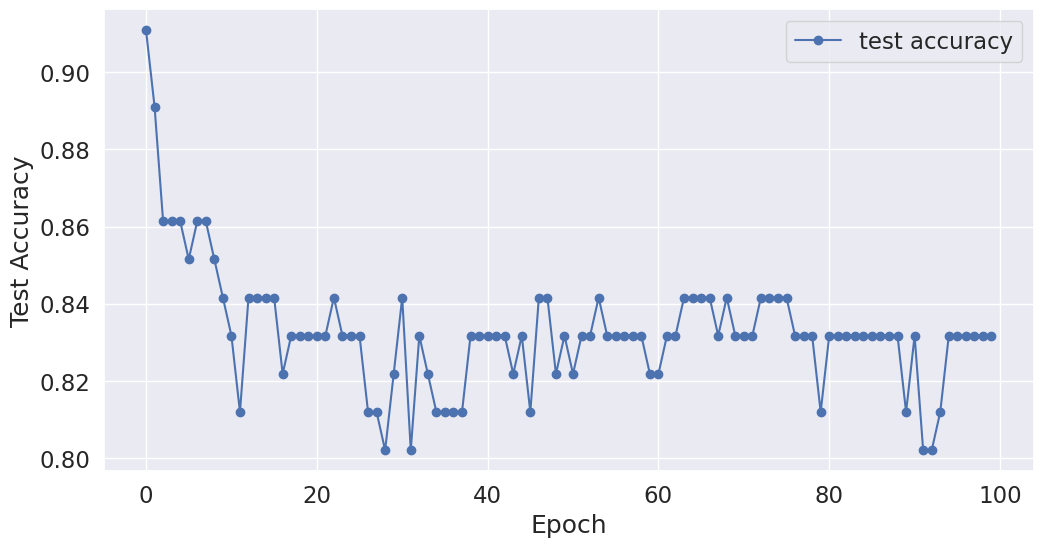

In [24]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(test_acc, 'b-o', label="test accuracy")


# Label the plot.
plt.title("")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.legend()

plt.show()

In [28]:
def acc():
    accuracy_list = []

    for i in range(len(sentences)):
        tokenized_sentence = tokenizer.encode(sentences[i])
        input_ids = torch.tensor([tokenized_sentence]).cuda()

        with torch.no_grad():
            output = model(input_ids)

        label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

        # join bpe split tokens
        tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
        new_tokens, new_labels = [], []
        for token, label_idx in zip(tokens, label_indices[0]):
            if token.startswith("##"):
                new_tokens[-1] = new_tokens[-1] + token[2:]
            else:
                new_labels.append(tag_values[label_idx])
                new_tokens.append(token)

        new_labels = new_labels[1:-2]
        accuracy_list.append(accuracy_score(new_labels, labels[i]))

        print("\nPredict labels: ",new_labels)
        print("Actual labels: ",labels[i])

        return statistics.mean(accuracy_list)

In [29]:
acc()

0

Predict labels:  ['0', '0', '0', 'A', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', 'Q', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', 'Q', '0', '0', '0', '0', '0', 'Q', 'A', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', 'R', 'R', 'R', '0', '0', '0', '0', '0', '0', '0', '0', 'M', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'R', 'R', 'R', 'R', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0

0.8316831683168316